In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

In [2]:
sns.set(font_scale=1.4)
sns.set_style({'font.family': 'serif',
               'fontname': 'Times New Roman'})

In [ ]:
detatran_2017_df = pd.read_csv('datatran2017.csv', sep = ';', encoding = 'latin-1')

In [4]:
detatran_2018_df = pd.read_csv('data/datatran2018.csv', sep = ';', encoding = 'latin-1')

In [5]:
detatran_2019_df = pd.read_csv('data/datatran2019.csv', sep = ';', encoding = 'latin-1')

In [6]:
detatran_2020_df = pd.read_csv('data/datatran2020.csv', sep = ';', encoding = 'latin-1')

In [7]:
detatran_2021_df = pd.read_csv('data/datatran2021.csv', sep = ';', encoding = 'latin-1')

In [8]:
datatran_df = pd.concat([
                detatran_2017_df, detatran_2018_df,
                detatran_2019_df, detatran_2020_df, detatran_2021_df])

In [9]:
del detatran_2017_df, detatran_2018_df,
del detatran_2019_df, detatran_2020_df, detatran_2021_df

In [10]:
datatran_df.dtypes

id                        float64
data_inversa               object
dia_semana                 object
horario                    object
uf                         object
br                        float64
km                         object
municipio                  object
causa_acidente             object
tipo_acidente              object
classificacao_acidente     object
fase_dia                   object
sentido_via                object
condicao_metereologica     object
tipo_pista                 object
tracado_via                object
uso_solo                   object
pessoas                     int64
mortos                      int64
feridos_leves               int64
feridos_graves              int64
ilesos                      int64
ignorados                   int64
feridos                     int64
veiculos                    int64
latitude                   object
longitude                  object
regional                   object
delegacia                  object
uop           

In [11]:
datatran_df['data_inversa'] = pd.to_datetime(datatran_df['data_inversa'], 
                                             yearfirst = True,
                                             format = '%Y-%m-%d')

In [12]:
datatran_df.sort_values(by = 'data_inversa', inplace = True)

In [13]:
datatran_df.head(2)

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,8.0,2017-01-01,domingo,00:00:00,PR,376.0,112,PARANAVAI,Fenômenos da Natureza,Queda de ocupante de veículo,...,1,0,0,1,1,"-23,09880731","-52,38789369",SR-PR,DEL7/7,UOP05/PR
213,272.0,2017-01-01,domingo,19:20:00,PE,232.0,"408,9",SERRA TALHADA,Desobediência às normas de trânsito pelo condutor,Colisão transversal,...,2,0,0,2,2,"-8,0578381","-34,8828969",SR-PE,DEL11/4,UOP01/PE


In [14]:
datatran_st = datatran_df['data_inversa'].groupby(datatran_df['data_inversa'].dt.to_period('D')).agg('count').to_frame()

In [15]:
datatran_st.head(5)

,data_inversa
data_inversa,
2017-01-01,313
2017-01-02,260
2017-01-03,233
2017-01-04,229
2017-01-05,210


In [16]:
datatran_st.shape

(1642, 1)

In [17]:
datatran_st.columns = ['acidentes']

In [18]:
datatran_st

,acidentes
data_inversa,
2017-01-01,313
2017-01-02,260
2017-01-03,233
2017-01-04,229
2017-01-05,210
...,...
2021-06-26,218
2021-06-27,177
2021-06-28,164


/home/lima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


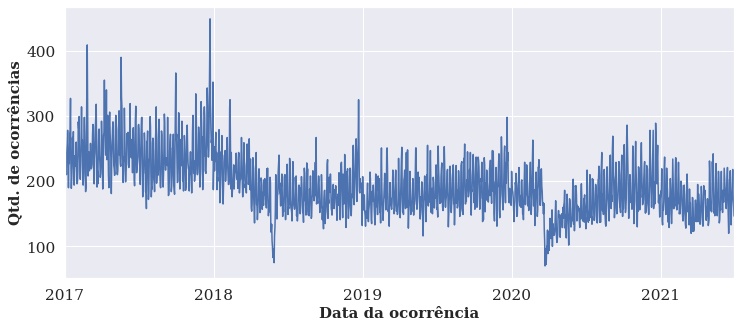

In [19]:
datatran_st_plot = datatran_st.plot(figsize=(12,5))

datatran_st_plot.set_xlabel('Data da ocorrência',
                            fontsize=15,
                            weight='bold')

datatran_st_plot.set_ylabel('Qtd. de ocorrências',
                            fontsize=15,
                            weight='bold')

datatran_st_plot.legend().remove()

figure = datatran_st_plot.get_figure()
figure.show()

In [20]:
decomposicao_st = seasonal_decompose(datatran_st, period = 30)

/home/lima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


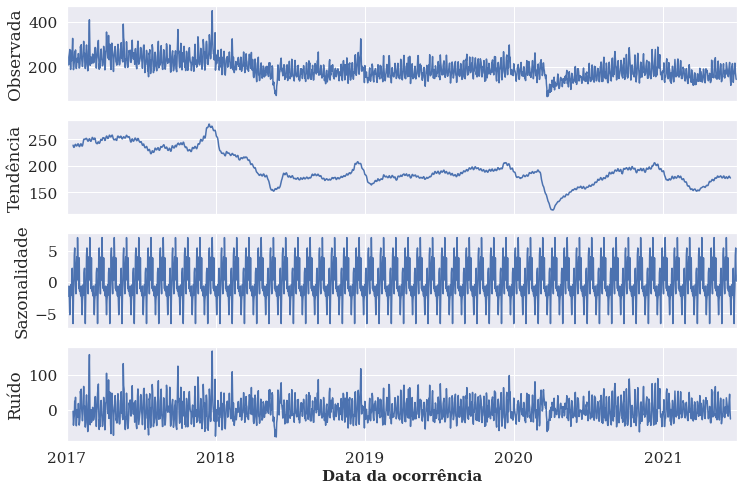

In [21]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(12,8))

decomposicao_st.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observada')

decomposicao_st.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Tendência')

decomposicao_st.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Sazonalidade')

decomposicao_st.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Ruído')

axes[3].set_xlabel('Data da ocorrência',
                    fontsize=15,
                    weight='bold')

fig.show()

In [22]:
X = datatran_st.values

In [23]:
len(X)

1642

In [24]:
tam = int(len(X) * 0.90)
treino, teste = X[0:tam], X[tam:len(X)]

In [25]:
print('treino = {}, teste = {}'.format(len(treino), len(teste)))

treino = 1477, teste = 165


 Encontrando os melhores valores para p, d, e q¶
p --> valor atual depende dos p valores anteriores;
d --> grau da tendência (linear, quadrática etc.);
q --> quantidade de observações passadas que a série de relaciona bem.

In [26]:
p = d = q = range(0,5)

In [27]:
print('p = {}\nd = {}\nq = {}'.format(p, d, q))

p = range(0, 5)
d = range(0, 5)
q = range(0, 5)


In [28]:
combinacoes_pdq = list(itertools.product(p,d,q))

In [29]:
combinacoes_pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [30]:
len(combinacoes_pdq)

125

In [31]:
%%time

menor_aic = -1
melhor_pdq = (0, 0, 0)

for pdq in combinacoes_pdq:
    try:
        model_arima = ARIMA(treino, order = pdq)
        model_arima_fit = model_arima.fit()
        
        print(pdq, model_arima_fit.aic)
        
        if menor_aic == -1:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
        elif model_arima_fit.aic < menor_aic:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
    except:
        continue

/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


(0, 0, 0) 15547.472039668495
(0, 0, 1) 14762.840703318276
(0, 0, 2) 14514.496455507597
(0, 0, 3) 14451.983521130398
(0, 0, 4) 14430.86846297813
(0, 1, 0) 14684.227519149461
(0, 1, 1) 14685.829941452717
(0, 1, 2) 14281.796803607505
(0, 1, 3) 14211.921749366486
(0, 1, 4) 14213.407361135545
(0, 2, 0) 15715.398927541808
(0, 2, 1) 14684.557295666455
(0, 2, 2) 14686.201035784152


/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(0, 2, 3) 14287.11652562038
(0, 2, 4) 14217.170043607412
(1, 0, 0) 14475.33007007651
(1, 0, 1) 14446.602144616838
(1, 0, 2) 14291.755028896046
(1, 0, 3) 14222.533893336258
(1, 0, 4) 14223.911938375904
(1, 1, 0) 14685.97678781631
(1, 1, 3) 14213.822923799029
(1, 1, 4) 14182.785607860935
(1, 2, 0) 15433.528404931458
(1, 2, 3) 14248.386727485546


/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 2, 4) 14218.966877376373
(2, 0, 0) 14444.856882026721
(2, 0, 1) 14331.903042976337
(2, 0, 2) 14253.805576989835
(2, 0, 3) 14224.417283351377
(2, 0, 4) 14190.3912683398
(2, 1, 0) 14640.198435319002
(2, 1, 2) 14015.035370038824
(2, 1, 3) 13619.491233173558


/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


(2, 1, 4) 13579.654116012072
(2, 2, 0) 15349.863002242397
(2, 2, 2) 14169.279459622277
(3, 0, 0) 14446.012869731696
(3, 0, 1) 14173.85303328033
(3, 0, 2) 13898.324063354545
(3, 0, 3) 13618.519435796772
(3, 0, 4) 13585.098252779419
(3, 1, 0) 14487.13407044553
(3, 1, 1) 14044.95455152915
(3, 1, 2) 13861.639686007105
(3, 1, 3) 13581.33782763202
(3, 1, 4) 13581.631015120309
(3, 2, 0) 15271.914911203552
(3, 2, 2) 14049.447003493693
(3, 2, 3) 13864.730657154272
(4, 0, 0) 14379.747421505082
(4, 0, 1) 14051.088659511437
(4, 0, 2) 13785.878904489644
(4, 0, 3) 13587.986355982779
(4, 0, 4) 13586.590081927801
(4, 1, 0) 14240.531286809428
(4, 1, 1) 13952.151518463555
(4, 1, 2) 13711.543319980594
(4, 1, 3) 13582.83083187512
(4, 1, 4) 13581.62329009736
(4, 2, 0) 15129.102412858441


/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 2, 2) 13956.022502198985
(4, 2, 3) 13720.307574195655
CPU times: user 2min 8s, sys: 26.4 s, total: 2min 34s
Wall time: 2min


In [32]:
print('menor_aic = {}, melhor_pdq = {}'.format(menor_aic, melhor_pdq))

menor_aic = 13579.654116012072, melhor_pdq = (2, 1, 4)


In [33]:
lista_historico = list(treino)
lista_previsoes = list()

In [34]:
%%time

for indice in range(len(teste)):
    modelo = ARIMA(lista_historico, order = melhor_pdq)
    modelo_fit = modelo.fit(disp = 0)
    previsao = modelo_fit.forecast()[0]
    lista_previsoes.append(previsao)
    lista_historico.append(teste[indice])
    
    print('previsto = {}, esperado = {}'.format(previsao, teste[indice]))

previsto = [200.13461626], esperado = [187]
previsto = [173.17014048], esperado = [158]
previsto = [143.68195793], esperado = [137]
previsto = [138.85224591], esperado = [174]
previsto = [173.80408235], esperado = [129]
previsto = [178.2891726], esperado = [160]
previsto = [196.59951341], esperado = [182]
previsto = [186.86742326], esperado = [204]
previsto = [170.23083978], esperado = [187]
previsto = [147.96938537], esperado = [150]
previsto = [139.46537532], esperado = [135]
previsto = [155.34324657], esperado = [152]
previsto = [183.53345892], esperado = [194]
previsto = [206.0550781], esperado = [234]
previsto = [208.39971457], esperado = [200]
previsto = [173.82168823], esperado = [158]
previsto = [142.43576646], esperado = [158]
previsto = [145.58346033], esperado = [165]
previsto = [168.91340834], esperado = [162]
previsto = [191.19664456], esperado = [208]
previsto = [216.59992754], esperado = [236]
previsto = [213.79303129], esperado = [235]
previsto = [191.76166354], esperad

/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


previsto = [177.47404542], esperado = [167]
previsto = [153.9604082], esperado = [127]
previsto = [120.69364967], esperado = [120]
previsto = [121.5945182], esperado = [143]
previsto = [149.73593132], esperado = [123]
previsto = [162.82659597], esperado = [175]
previsto = [188.33457609], esperado = [174]
previsto = [171.75176121], esperado = [157]
previsto = [142.39610392], esperado = [123]
previsto = [113.56171472], esperado = [126]
previsto = [118.77440226], esperado = [141]
previsto = [144.64054309], esperado = [138]
previsto = [164.93972977], esperado = [170]
previsto = [182.77561267], esperado = [171]
previsto = [168.08140577], esperado = [158]
previsto = [140.53199725], esperado = [138]
previsto = [118.47485698], esperado = [154]
previsto = [130.13456834], esperado = [156]
previsto = [152.45208891], esperado = [195]
previsto = [190.41854025], esperado = [138]
previsto = [174.22735458], esperado = [158]
previsto = [168.78879038], esperado = [180]
previsto = [152.64125385], esperad

/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


previsto = [149.17800561], esperado = [153]
previsto = [161.75644196], esperado = [167]
previsto = [186.36533388], esperado = [230]
previsto = [215.06152272], esperado = [203]
previsto = [193.08332189], esperado = [242]
previsto = [192.2256853], esperado = [186]
previsto = [160.04140329], esperado = [151]
previsto = [154.92530485], esperado = [166]
previsto = [178.50009329], esperado = [147]
previsto = [187.91236658], esperado = [181]
previsto = [204.26455246], esperado = [206]
previsto = [198.59941031], esperado = [227]
previsto = [186.72226786], esperado = [158]
previsto = [148.59647435], esperado = [152]


/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


previsto = [152.16671364], esperado = [147]
previsto = [166.63747614], esperado = [176]
previsto = [195.97710336], esperado = [199]
previsto = [208.76559104], esperado = [215]
previsto = [202.62893043], esperado = [205]
previsto = [178.88595724], esperado = [136]
previsto = [140.10199131], esperado = [141]
previsto = [146.19375735], esperado = [162]
previsto = [170.45782059], esperado = [156]
previsto = [186.13386754], esperado = [191]
previsto = [203.88252297], esperado = [215]
previsto = [198.68221129], esperado = [180]
previsto = [165.1277336], esperado = [177]
previsto = [152.43239957], esperado = [152]
previsto = [147.71015078], esperado = [186]
previsto = [180.98517212], esperado = [169]
previsto = [193.12839312], esperado = [168]


/home/lima/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


previsto = [197.71284995], esperado = [220]
previsto = [202.89731135], esperado = [204]
previsto = [175.90057364], esperado = [187]
previsto = [159.46043276], esperado = [176]
previsto = [161.23655358], esperado = [162]
previsto = [175.39982092], esperado = [158]
previsto = [192.23632272], esperado = [188]
previsto = [206.96471096], esperado = [207]
previsto = [200.16761735], esperado = [221]
previsto = [185.79316262], esperado = [173]
previsto = [155.78963489], esperado = [147]
previsto = [151.38710478], esperado = [120]
previsto = [157.61433847], esperado = [150]
previsto = [185.44637045], esperado = [202]


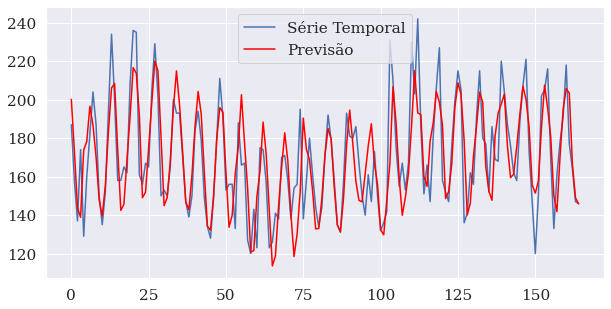

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(teste, label="Série Temporal")
plt.plot(lista_previsoes, color='red', label="Previsão")
plt.legend()
plt.show()

In [ ]:
print('teste = {}, previsão = {}'.format(len(teste), len(lista_previsoes)))

teste = 165, previsão = 165


In [ ]:
error = mean_squared_error(teste, lista_previsoes)
print('Test MSE: %.4f' % error)

Test MSE: 323.6500


In [ ]:
# https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima

#